# Extracting sources

* Extracting sources from a fits file (SExtractor via sewpy)

In [34]:
import os , glob
import matplotlib.pyplot as plt
import sewpy
import random
import numpy as np

from scipy.stats import sigmaclip
from astropy.io import fits
from math import *
from sklearn.cluster import KMeans
from scipy.spatial import distance_matrix

import networkx as nx

## Constants
DEG2ARCSEC= 3600.

## Functions

* In  ubuntu you can use: "sudo apt install sextractor" to install sextractor
* In runsextractor, set the path for the binary of SExtractor ($>  which sextractor)

In [35]:
def runsextractor(image_file, wdir="./", detect_thresh=3.5, analysis_thresh=3.0):
    params = ['NUMBER', 'FLUX_ISO', 'FLUXERR_ISO', 'FLUX_AUTO', 'FLUXERR_AUTO', 'FLUX_BEST', 'FLUXERR_BEST', 'BACKGROUND', 
              'THRESHOLD', 'FLUX_MAX', 'XMAX_IMAGE', 'YMAX_IMAGE', 'XPEAK_IMAGE', 'YPEAK_IMAGE', 'ALPHAPEAK_J2000', 
              'DELTAPEAK_J2000', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_SKY', 'DELTA_SKY', 'ALPHA_J2000', 'DELTA_J2000']

    convfile= "/home/stephane/soft/sextractor/config/gauss_2.0_5x5.conv"
    # convfile= "/home/stephane/soft/sextractor/config/default.conv"
    
    config = {"DETECT_THRESH":detect_thresh, "ANALYSIS_THRESH":analysis_thresh, "FILTER_NAME":convfile}

    sew = sewpy.SEW(workdir=wdir, sexpath="/usr/bin/sextractor",params=params, config=config)

    out = sew(image_file)
    data = out["table"]
    
    ra, dec, flux, label = data['ALPHA_J2000'], data['DELTA_J2000'], data['FLUX_MAX'], data['NUMBER'].astype('int')
    
    return ra, dec, flux, label


## get some parameters from the fits.
def getInfoFits(fitsimage):
    hdulist = fits.open(fitsimage)
    
    hdr = hdulist[0].header
    nx = int(hdr['NAXIS1'])
    ny = int(hdr['NAXIS2'])
    bmin = float(hdr['BMIN']) * DEG2ARCSEC
    bmaj = float(hdr['BMAJ']) * DEG2ARCSEC
    ar = sqrt(bmin*bmaj)
    lonpole = float(hdr['CRVAL1'])
    latpole = float(hdr['CRVAL2'])
    
    freq = float(hdr['CRVAL3']) / 1e9     ### frequency in GHz
    dx = abs(float(hdr['CDELT1'])) * DEG2ARCSEC ## dx in arcsec
    
    return(freq)


## RMS estimation
def getRMSfits(fitsimage , nsample=40 , size= 20):
    
    random.seed()
    
    hdulist = fits.open(fitsimage)
    
    hdr = hdulist[0].header
    nx = int(hdr['NAXIS1'])
    ny = int(hdr['NAXIS2'])
    
    data = hdulist[0].data
    
    rms = []
    for i in range(nsample):
        ix = random.randint(size,int(nx/2)-size)
        iy = random.randint(size,int(ny/2)-size)
        fx = random.random()
        fy = random.random()
        
        if fx < 0.5:
            ixcenter = ix
        else:
            ixcenter = nx - ix
            
        if fy < 0.5:
            iycenter = iy
        else:
            iycenter = ny - iy
            
        datrms = data[0, 0, ixcenter-size:ixcenter+size, iycenter-size:iycenter+size]
        rms.append(np.std(datrms))
        
    
    c, low, upp = sigmaclip(rms , 3.0 , 3.0)

    rmsestimated = np.median(c)    
    return(rmsestimated)   

## estimatng the best RMS noise for all fits file in a directory
def getBestRMS(direc, ext):
    files = glob.glob("%s/%s"%(direc,ext))
    
    bestrms= 1e9
    bestfile= ""
    for f in files:
        rms=  getRMSfits("%s/%s"%(direc,f))*1e3     ### RMS noise in mJy
        if rms < bestrms:
            bestrms = rms
            bestfile= f
            
    return(bestfile, bestrms)
        

## Main

* Extract the sources for each band
* The SIGMA value for the detection can be set. As a default it is set to 3.5.
* The flux indicated is in Jy/b
* The frequency (GHz) of each band is obtained by getInfoFits(band) where band is the fits file
* Note that SExtractor estimates various flux (different methods).
* In case of several images we estimate the best rms noise.

**In the example below we take the source J0811-4929**
The image with the best RMS noise is selected (bestfile) but it could be changed manually if needed.

In [36]:
## Directories
wdir =      "/home/stephane/Science/RadioGalaxy/ALMA/DeepField/analysis/c"
sourcedir= "/home/stephane/Science/RadioGalaxy/ALMA/DeepField/bosscha/J0811-4929"

## detection sigma
SIGMA= 3.5


##############################
## BAND 3
print("## Band 3")
os.chdir("%s/Band 3"%(sourcedir))
bestfile ,rms = getBestRMS("./", "*cont4.image.fits")
print("## Best rms noise for file: %s (%3.3f mJy)"%(bestfile, rms))
ra3, dec3 , flux3 , label3 = runsextractor(bestfile,detect_thresh=SIGMA)
freq3= getInfoFits(bestfile)

print("## Freq: %3.3f GHz"%(freq3))
print(flux3)
fre3= []
for i in range(len(flux3)):
    fre3.append(freq3)

## BAND 4
print("\n## Band 4")
os.chdir("%s/Band 4"%(sourcedir))
bestfile ,rms = getBestRMS("./", "*cont4.image.fits")
print("## Best rms noise for file: %s (%3.3f mJy)"%(bestfile, rms))
ra4, dec4 , flux4 , label4 = runsextractor(bestfile,detect_thresh=SIGMA)
freq4= getInfoFits(bestfile)

print("## Freq: %3.3f GHz"%(freq4))
print(flux4)
fre4= []
for i in range(len(flux4)):
    fre4.append(freq4)

## BAND 6
print("\n## Band 6")
os.chdir("%s/Band 6"%(sourcedir))
bestfile ,rms = getBestRMS("./", "*cont4.image.fits")
print("## Best rms noise for file: %s (%3.3f mJy)"%(bestfile, rms))
ra6, dec6 , flux6 , label6 = runsextractor(bestfile,detect_thresh=SIGMA)
freq6= getInfoFits(bestfile)

print("## Freq: %3.3f GHz"%(freq6))
print(label6)
print(flux6)
fre6= []
for i in range(len(flux6)):
    fre6.append(freq6)

## BAND 7
print("\n## Band 7")
os.chdir("%s/Band 7"%(sourcedir))
bestfile ,rms = getBestRMS("./", "*cont4.image.fits")
print("## Best rms noise for file: %s (%3.3f mJy)"%(bestfile, rms))
ra7, dec7 , flux7 , label7 = runsextractor(bestfile,detect_thresh=SIGMA)
freq7= getInfoFits(bestfile)
print("## Freq: %3.3f GHz"%(freq7))
print(flux7)
fre7= []
for i in range(len(flux7)):
    fre7.append(freq7)


## BAND 8
print("\n## Band 8")
os.chdir("%s/Band 8"%(sourcedir))
bestfile ,rms = getBestRMS("./", "*cont4.image.fits")
print("## Best rms noise for file: %s (%3.3f mJy)"%(bestfile, rms))
ra8, dec8 , flux8 , label8 = runsextractor(bestfile,detect_thresh=SIGMA)
freq8= getInfoFits(bestfile)

print("## Freq: %3.3f GHz"%(freq8))
print(flux8)
fre8= []
for i in range(len(flux8)):
    fre8.append(freq8)

Output catalog ./uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


## Band 3
## Best rms noise for file: ./uid___A002_Xb5bd46_X55ee.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.075 mJy)
## Freq: 97.495 GHz
 FLUX_MAX
    ct   
---------
0.3540781

## Band 4
## Best rms noise for file: ./uid___A002_Xb55f4e_X36b4.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.070 mJy)


Output catalog ./uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


## Freq: 144.995 GHz
FLUX_MAX
   ct   
--------
0.272246

## Band 6
## Best rms noise for file: ./uid___A002_Xc3c940_X18d2.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.047 mJy)


Output catalog ./uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it
Output catalog ./uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.cat.txt already exists, I will overwrite it


## Freq: 225.487 GHz
NUMBER
------
     1
     2
     3
     4
     5
     6
     7
     8
     9
    10
    11
    12
    13
    14
    15
  FLUX_MAX  
     ct     
------------
0.0002331772
0.0001807319
   0.0002191
0.0002086769
   0.1680943
0.0002277311
0.0002714049
0.0002440881
0.0002097708
0.0001939541
0.0002051878
0.0002243967
0.0002217224
0.0002012565
0.0002118368

## Band 7
## Best rms noise for file: ./uid___A002_Xb05734_X632.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.105 mJy)
## Freq: 343.495 GHz
 FLUX_MAX
    ct   
---------
0.1399343

## Band 8
## Best rms noise for file: ./uid___A002_Xba4d35_Xca1b.ms.split.cal-CALIBRATE_PHASE-J0811-4929.ms.cont4.image.fits (0.704 mJy)
## Freq: 484.649 GHz
 FLUX_MAX
    ct   
---------
0.1259729


## Plots and first analysis



* Flux vs. frequency is in LogLog since the synchrotron law is with the form : <br>
Flux \propto Freq^(alpha) <br>
alpha is the spectral index (sometimes -alpha is used) <br>

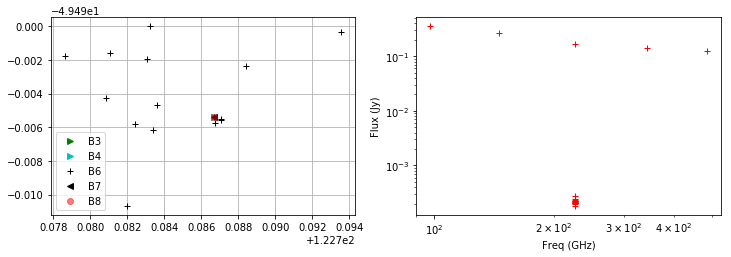

In [37]:
fig= plt.figure(figsize=(12,8))

ax= plt.subplot(221)
plt.grid(True)
plt.plot(ra3,dec3,"g>", label="B3")
plt.plot(ra4,dec4,"c>", label="B4")
plt.plot(ra6,dec6,"k+", label="B6")
plt.plot(ra7,dec7,"k<", label="B7")
plt.plot(ra8,dec8,"ro", alpha=0.5, label="B8")
plt.legend()

plt.subplot(222)
plt.xlabel("Freq (GHz)")
plt.ylabel("Flux (Jy)")

plt.loglog(fre3,flux3,"r+")
plt.loglog(fre4,flux4,"r+")
plt.loglog(fre6,flux6,"r+")
plt.loglog(fre7,flux7,"r+")
plt.loglog(fre8,flux8,"r+")

plt.show()

In [38]:
## Functions

def spectralIndex(f, flux):
    spix = (log(flux[1]) - log(flux[0])) / (log(f[1]) - log(f[0]))
    
    return(spix)

In [39]:
## find counterparts
##  
## ra, dec: array of all sources
## label: each source should have a different label
## 

class ctrprt:
    
    def __init__(self, ra, dec, label):
        self.ra= ra
        self.dec= dec
        self.label= label
        
    def setFlux(self, flux):
        self.flux= flux
              
    ## basic algorithm to connect one source at different frequencies.
    ## IMPORTANT: tolerance should be small enough to avoid two different sources at the "same" position
    def getGraphSource(self, tolerance= 0.5):
        K= []
        G=nx.Graph()
        tolerance /= DEG2ARCSEC
        
        for i in range(len(self.ra)):
            K.append([self.ra[i], self.dec[i]])
            G.add_node(i)
            dist= distance_matrix(K, K)
        
        
        pair= []
        for i in range(len(self.ra)):
            for j in range(i):
                if dist[i,j] < tolerance and self.label[i] != self.label[j]:
                    G.add_edge(i,j, weight= dist[i,j])
                    
        ## removing isolated nodes (detections)
        isol= list(nx.isolates(G))
        G.remove_nodes_from(list(nx.isolates(G)))
        
        return(G , isol)
    
    
    def getMultipleDetection(self, G):
        cont= True
        sources=[]
        
        while cont:
            list_node= list(G.nodes)
            first_node= list_node[0]
            
            ## all nodes reachable from one node (same source)
            connected_nodes= list(nx.descendants(G,first_node))
            connected_nodes.append(first_node)
            connected_nodes.sort()
            
            sources.append(connected_nodes)
            
            for v in connected_nodes:
              G.remove_node(v)
            
            if len(G.nodes)==0:
                cont= False
        
        return(sources)

In [40]:
ra= []
dec= []
label=[]
flux=[]
frequency=[]

## THIS PART is VERY UGLY!! Should be changed...
##
for d in ra3:
    ra.append(d)
    label.append("B3")
    frequency.append(freq3)
for d in ra4:
    ra.append(d)
    label.append("B4")
    frequency.append(freq4)   
for d in ra6:
    ra.append(d)
    label.append("B6")
    frequency.append(freq6)
for d in ra7:
    ra.append(d)
    label.append("B7")
    frequency.append(freq7)  
for d in ra8:
    ra.append(d)
    label.append("B8")
    frequency.append(freq8) 
    
for d in dec3:
    dec.append(d)
for d in dec4:
    dec.append(d)   
for d in dec6:
    dec.append(d)   
for d in dec7:
    dec.append(d)
for d in dec8:
    dec.append(d)
    
for d in flux3:
    flux.append(d)
for d in flux4:
    flux.append(d)
for d in flux6:
    flux.append(d)   
for d in flux7:
    flux.append(d)
for d in flux8:
    flux.append(d)    

t = ctrprt(ra,dec,label)

## the parameter is the maximum distance in Arcsec to match 2 sources
## if the minimum distance is too large, it fails since it would pair two sources at the same frequency...
g, isol= t.getGraphSource(0.5)  

sources= t.getMultipleDetection(g)
print(sources)


[[0, 1, 6, 17, 18]]


## Source: 1
[0, 1, 6, 17, 18]
[97.49457654734, 144.99457897739998, 225.48704912489998, 343.4946128273, 484.64868737859996]
[0.3540781, 0.272246, 0.1680943, 0.1399343, 0.1259729]


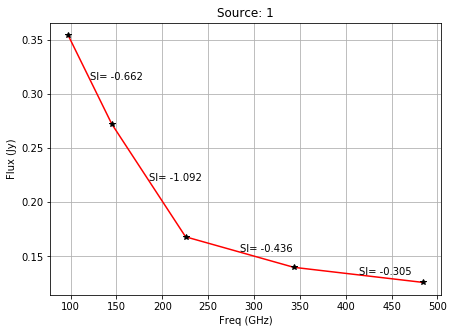

In [41]:
## spectral index and plot for each sources

nsource= 1
for s in sources:
    print("## Source: %d"%(nsource))
    print(s)
    
    fr= [frequency[i] for i in s]
    fl= [flux[i] for i in s]
    
    print(fr)
    print(fl)
    
    fig= plt.figure(figsize=(7,5))
    ax= plt.subplot(111)
    plt.title("Source: %d"%(nsource))
    plt.grid(True)
    plt.xlabel("Freq (GHz)")
    plt.ylabel("Flux (Jy)")
    plt.plot(fr, fl,"r-")
    plt.plot(fr, fl,"k*")
    
    for i in range(1,len(fr)):
        si= spectralIndex([fr[i-1],fr[i]],[fl[i-1],fl[i]] )
        plt.text(0.5*(fr[i-1]+fr[i]) , 0.5*(fl[i-1]+fl[i]) , "SI= %3.3f"%(si) )
    
    plt.show()
       
    nsource += 1
    